![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/visual-nlp/1.1.Text_recognition.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

For get the trial license please go to:

https://www.johnsnowlabs.com/install/

### Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

In [ ]:
 from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, visual

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.settings.enforce_versions=True
nlp.install(refresh_install=True, visual=True)

In [ ]:
# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_9005.json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==5.3.1, 💊Spark-Healthcare==5.3.0, 🕶Spark-OCR==5.3.0, running on ⚡ PySpark==3.4.0


In [ ]:
import pkg_resources
import pandas as pd
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

## Image to Text


    Image #0:
    Origin: file:/usr/local/lib/python3.10/dist-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


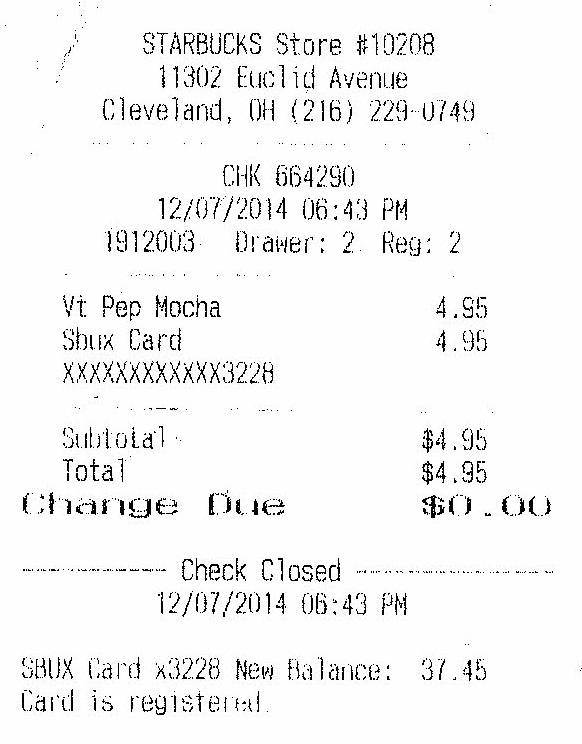

In [ ]:
image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_example_df = spark.read.format("binaryFile").load(image_path).cache()

visual.display_images(visual.BinaryToImage().transform(image_example_df))

In [ ]:
binary_to_image = visual.BinaryToImage()\
      .setInputCol("content")\
      .setOutputCol("image")

# Run OCR
ocr = visual.ImageToText()\
      .setInputCol("image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(65)
      #.setKeepLayout(True) # to preserve the layout of the input

image_to_text_pipeline = PipelineModel(stages=[
    binary_to_image,
    ocr
])

In [ ]:
result = image_to_text_pipeline.transform(image_example_df).cache()
result.select("pagenum", "text", "confidence").show()

result.printSchema()

+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|STARBUCKS Store #...|73.70487899780274|
+-------+--------------------+-----------------+

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- pagenum: integer (nullable = true)
 |-- confidence: double (nullable = true)
 |-- exception: string (nullable = true)
 |-- text: string (nullable = true)
 |-- positions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- mapping: array

In [ ]:
print("\n".join([row.text for row in result.select("text").collect()]))

STARBUCKS Store #19208
11902 Euclid Avenue
Cleveland, OH (216) 229-U749

CHK 664250
12/07/2014 06:43 PM
112003. Drawer: 2. Reg: 2

oBUX Card «3228 New Balance: 37.45
Card is registertd



## Image to HOCR

In [ ]:
def pipeline():

    # Transforrm PDF document to images per page
    binary_to_image = visual.BinaryToImage() \
        .setInputCol("content") \
        .setOutputCol("image") \
        .setImageType(visual.ImageType.TYPE_3BYTE_BGR)

    # Run OCR
    ocr = visual.ImageToHocr() \
        .setInputCol("image") \
        .setOutputCol("hocr") \
        .setIgnoreResolution(False)

    document_assembler = visual.HocrDocumentAssembler() \
        .setInputCol("hocr") \
        .setOutputCol("document")

    tokenizer = visual.HocrTokenizer() \
        .setInputCol("hocr") \
        .setOutputCol("token") \

    draw_annotations = visual.ImageDrawAnnotations() \
        .setInputCol("image") \
        .setInputChunksCol("token") \
        .setOutputCol("image_with_annotations") \
        .setFilledRect(False) \
        .setFontSize(10) \
        .setRectColor(visual.Color.red)

    pipeline = PipelineModel(stages=[
        binary_to_image,
        ocr,
        document_assembler,
        tokenizer,
        draw_annotations
    ])

    return pipeline

### Run pipeline and show results

In [ ]:
result = pipeline().transform(image_example_df).cache()
print(result.select("hocr").collect()[0].hocr)

  <div class='ocr_page' id='page_1' title='image "unknown"; bbox 0 0 582 744; ppageno 0; scan_res 199 199'>
   <div class='ocr_carea' id='block_1_1' title="bbox 103 32 474 124">
    <p class='ocr_par' id='par_1_1' lang='eng' title="bbox 103 32 474 124">
     <span class='ocr_line' id='line_1_1' title="bbox 143 32 434 56; baseline 0.003 -2; x_size 29.5; x_descenders 5.5; x_ascenders 6.8571429">
      <span class='ocrx_word' id='word_1_1' title='bbox 143 32 261 55; x_wconf 96'>STARBUCKS</span>
      <span class='ocrx_word' id='word_1_2' title='bbox 277 33 341 56; x_wconf 96'>Store</span>
      <span class='ocrx_word' id='word_1_3' title='bbox 357 33 434 55; x_wconf 94'>#19208</span>
     </span>
     <span class='ocr_line' id='line_1_2' title="bbox 160 65 407 89; baseline 0 -1; x_size 28.454166; x_descenders 5.4541669; x_ascenders 6">
      <span class='ocrx_word' id='word_1_4' title='bbox 160 65 221 88; x_wconf 66'>11902</span>
      <span class='ocrx_word' id='word_1_5' title='bbox 238

### Display recognized text on original image


    Image #0:
    Origin: file:/usr/local/lib/python3.10/dist-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


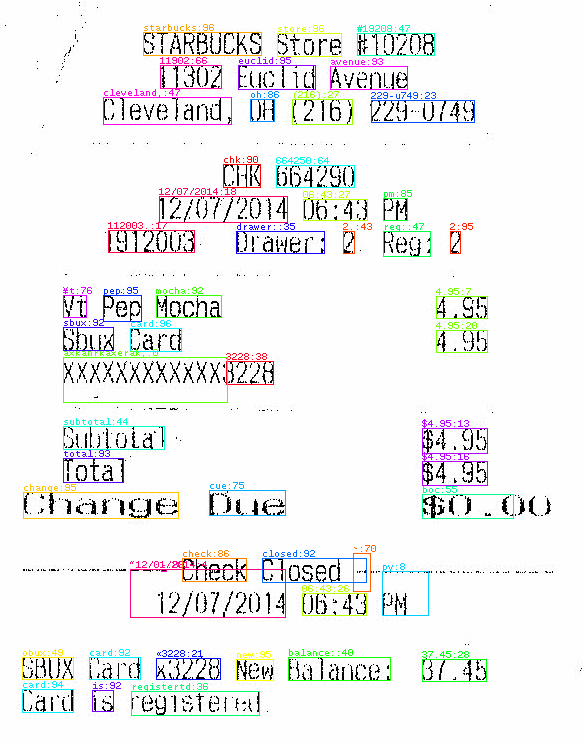

In [ ]:
visual.display_images(result, "image_with_annotations", width=1000)

## Pdf to Text

In [ ]:
pdf_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/test_document.pdf')
pdf_example_df = spark.read.format("binaryFile").load(pdf_path).cache()

visual.display_pdf(pdf_example_df)

In [ ]:
# Transform PDF document to images per page
pdf_to_image = visual.PdfToImage()\
      .setInputCol("content")\
      .setOutputCol("image")

# Run OCR
ocr = visual.ImageToText()\
      .setInputCol("image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(65)

pdf_to_text_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr
])

In [ ]:
result = pdf_to_text_pipeline.transform(pdf_example_df).cache()
result.select("pagenum", "text", "confidence").show()

+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      1|Patient Name\nFin...|83.06709993802585|
|      0|Patient Nam\nFina...| 84.6904648674859|
+-------+--------------------+-----------------+



In [ ]:
print("\n".join([row.text for row in result.select("text").collect()]))

Patient Name
Financial Number
Date of Girth
Patient Location

Random Hospital

 

 

 

H & P
Anemia Vitamin D2 $0,000 intl units (1.25 ma) oral
ALDASeIne capsule, 1 TAS, PO, V/eexly-Tue
Arthritis
Allergies

Tylenol for pain. Patient also takes Percocet al home, will add this on.
Chronic kidney disease
AY baseline. Monitor while divresing.
Hypertension
Blood pressures within tolerable ranges.
Pulmonary hypertension
Tricuspid regurgitation
ild-to-moderaie on echocardiogram last year

sholliish (cout)
sulfa drug (maculopapular rash)

 

Social History

Ever Smoked tobacco: Former Smoker
Alcohol use - frequency; None

Drug use: Never

Lab Results
07/10/77 05:30 to O7/16/17 05:30

 

Attending physician note-the patient was interviewed and examined. The appropriatc
information in power chart was reviewed. The patient was discussed wilh Dr, Persad. 143 1L 981H 26?
Patient may have @ mild degree oj heart failure. He and his wife were morc concernee with a
Ins peripheral edema. He has underly

## Skew correction


    Image #0:
    Origin: file:/usr/local/lib/python3.10/dist-packages/sparkocr/resources/ocr/pdfs/rotated/400/400_rot.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


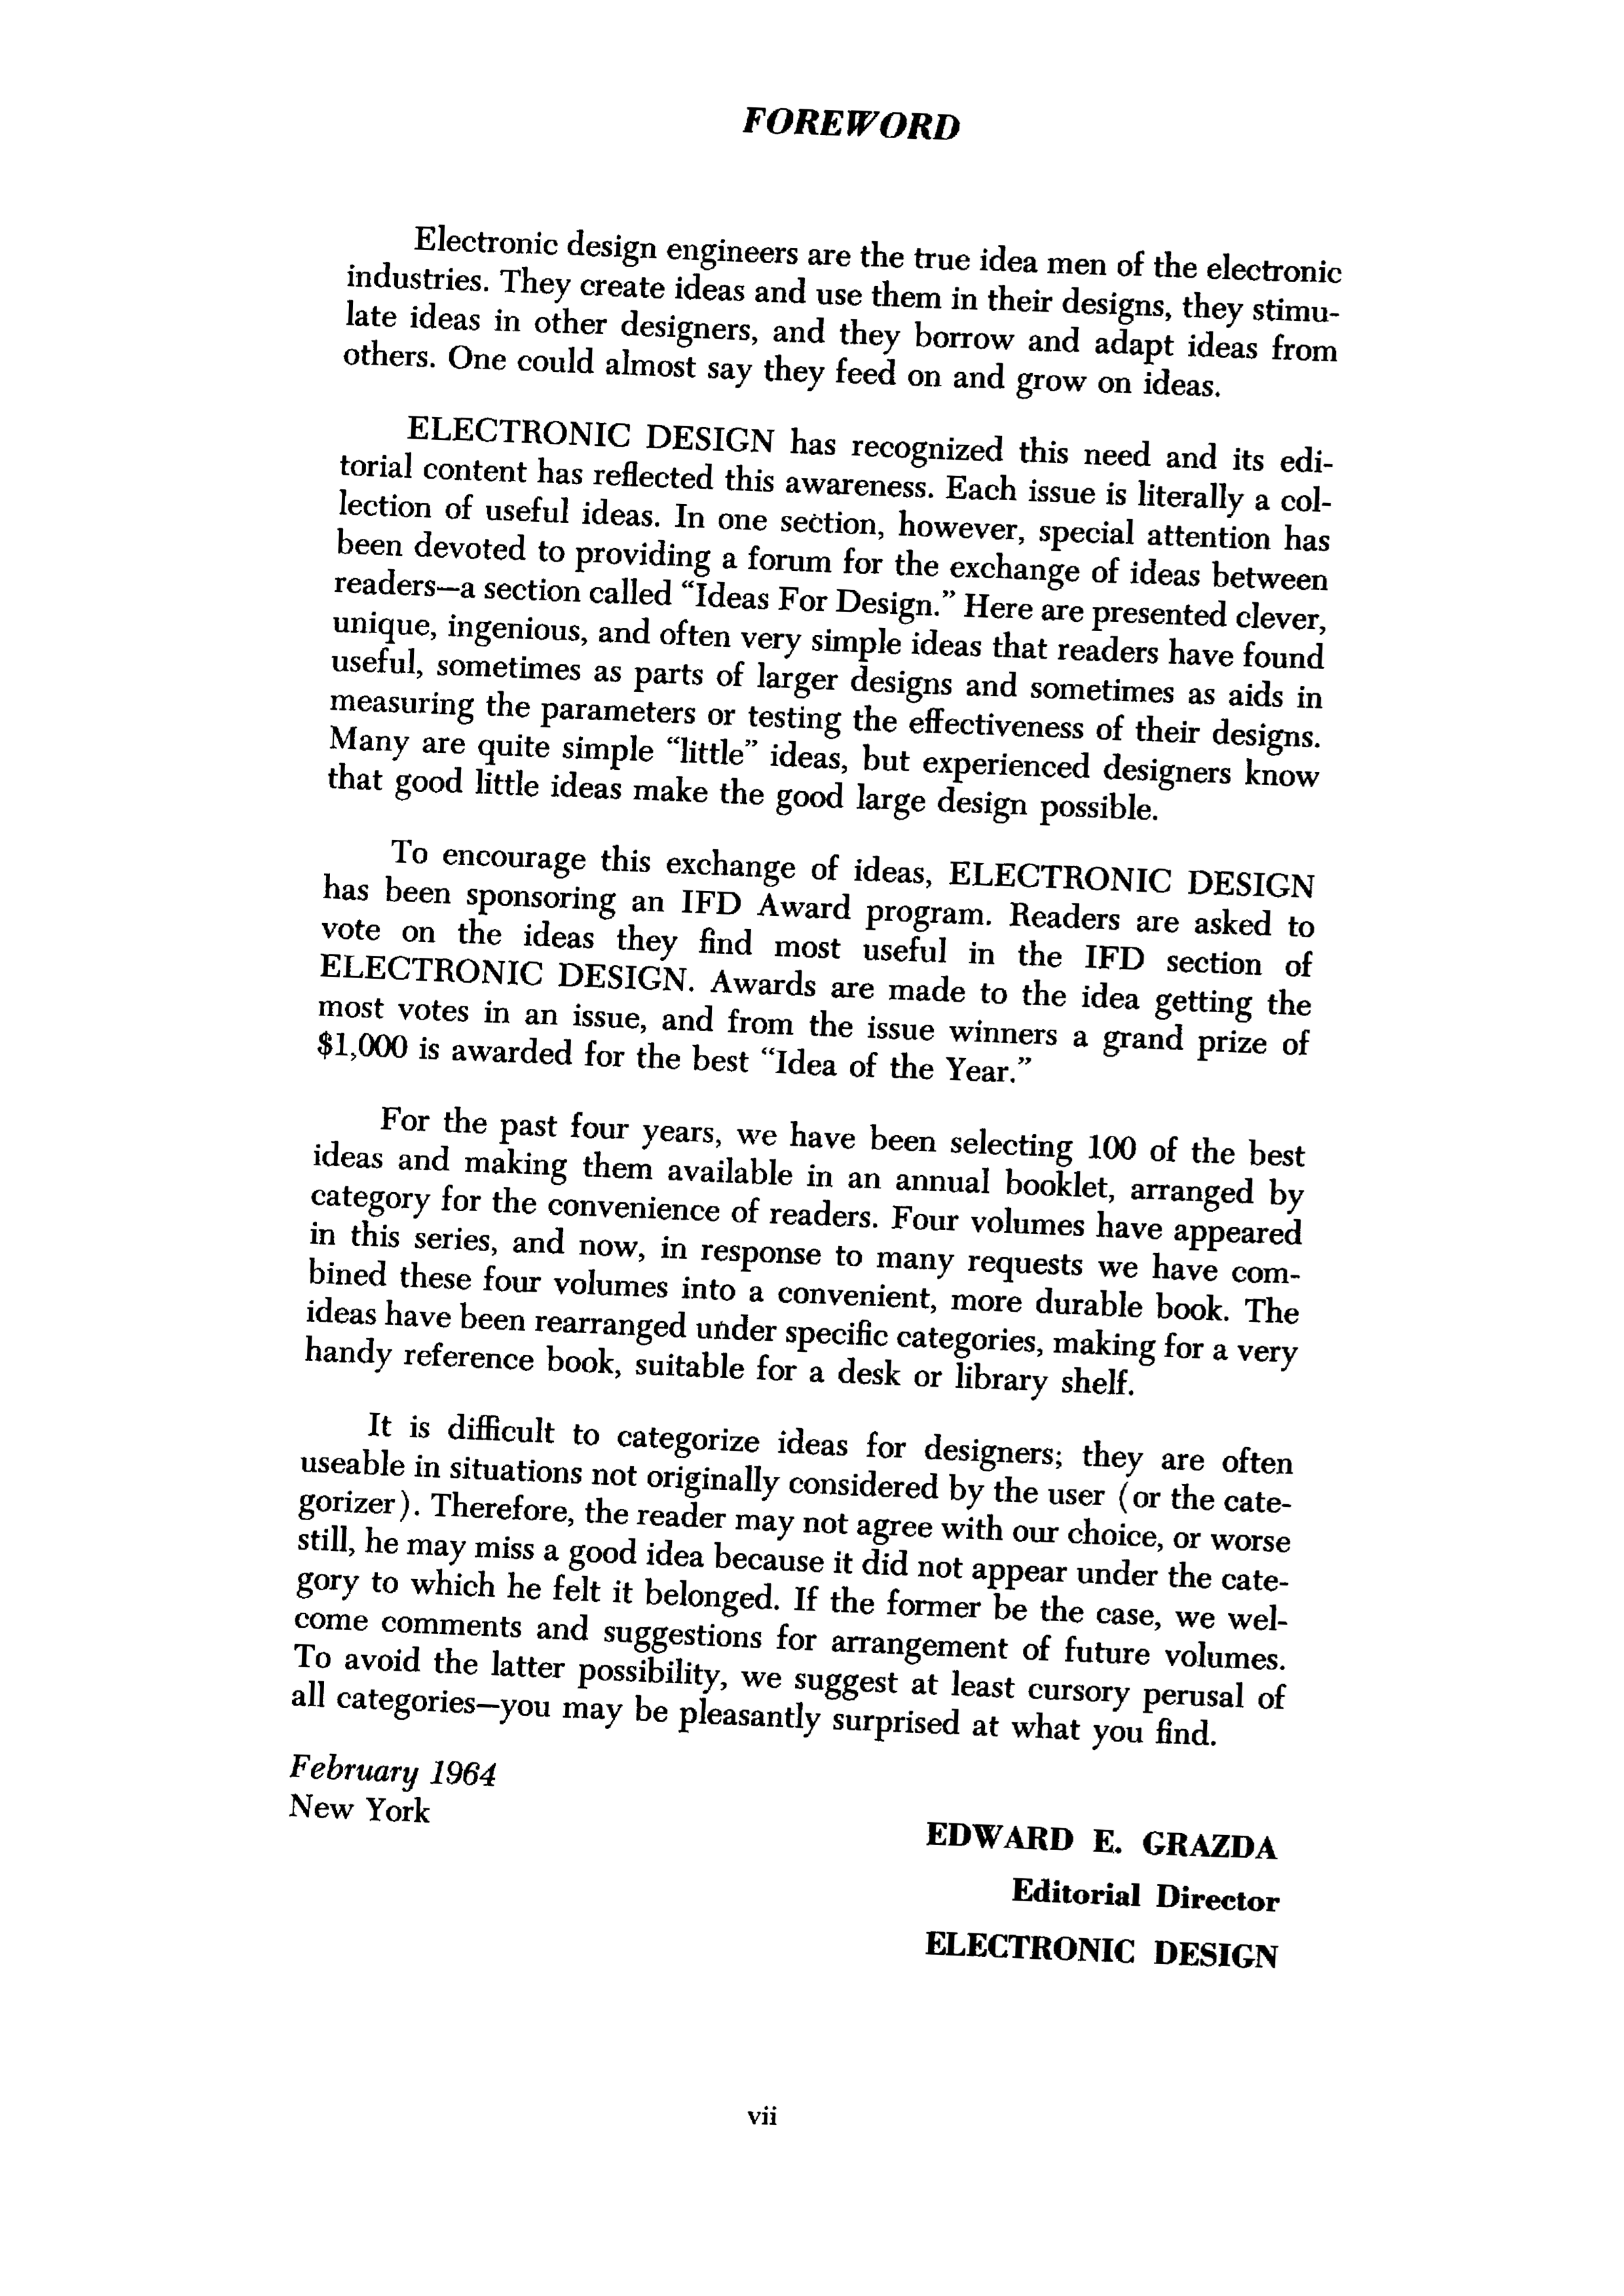

In [ ]:
pdf_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/rotated/400/400_rot.pdf')
pdf_rotated_df = spark.read.format("binaryFile").load(pdf_path).cache()

visual.display_pdf(pdf_rotated_df)

In [ ]:
def ocr_pipeline(skew_correction=False):

    # Transforrm PDF document to images per page
    pdf_to_image = visual.PdfToImage()\
          .setInputCol("content")\
          .setOutputCol("image")

    # Image skew corrector
    skew_corrector = visual.ImageSkewCorrector()\
          .setInputCol("image")\
          .setOutputCol("corrected_image")\
          .setAutomaticSkewCorrection(skew_correction)

    # Run OCR
    ocr = visual.ImageToText()\
          .setInputCol("corrected_image")\
          .setOutputCol("text")

    pipeline_ocr = PipelineModel(stages=[
        pdf_to_image,
        skew_corrector,
        ocr
    ])

    return pipeline_ocr

In [ ]:
result = ocr_pipeline(False).transform(pdf_rotated_df).cache()
print("\n".join([row.text for row in result.select("text").collect()]))

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

To encourage this exchange of ideas, ELECTRONIC DESIGN
has been sponsoring an IFD Award program. Readers are asked to
vote on the ideas they find most useful in the IFD section of

most votes in an issue, and from the issue winners a grand prize of
$1,000 is awarded for the best “Idea of the Year.”

handy reference book, suitable for a desk or library shelf,

It is difficult to categorize ideas for designers; they are often
useable in situations not originally considered by the user (or the cate-

come comments and suggestions for arrangement of future volumes.
To avoid the latter possibility, we Suggest at least cursory perusal of
all categories—you may be pleasantly surprised at what you find.

February 1964

In [ ]:
corrected_result = ocr_pipeline(True).transform(pdf_rotated_df).cache()
print("\n".join([row.text for row in corrected_result.select("text").collect()]))

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

ELECTRONIC DESIGN has recognized this need and its edi-
torial content has reflected this awareness. Each issue is literally a col-
lection of useful ideas. In one section, however, special attention has
been devoted to providing a forum for the exchange of ideas between
readers—a section called “Ideas For Design.” Here are presented clever,
unique, ingenious, and often very simple ideas that readers have found
useful, sometimes as parts of larger designs and sometimes as aids in
measuring the parameters or testing the effectiveness of their designs.
Many are quite simple “little” ideas, but experienced designers know
that good little ideas make the good large design possible.

To encourage this exchange of id


    Image #0:
    Origin: file:/usr/local/lib/python3.10/dist-packages/sparkocr/resources/ocr/pdfs/rotated/400/400_rot.pdf
    Resolution: 300 dpi
    Width: 2600 px
    Height: 3591 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


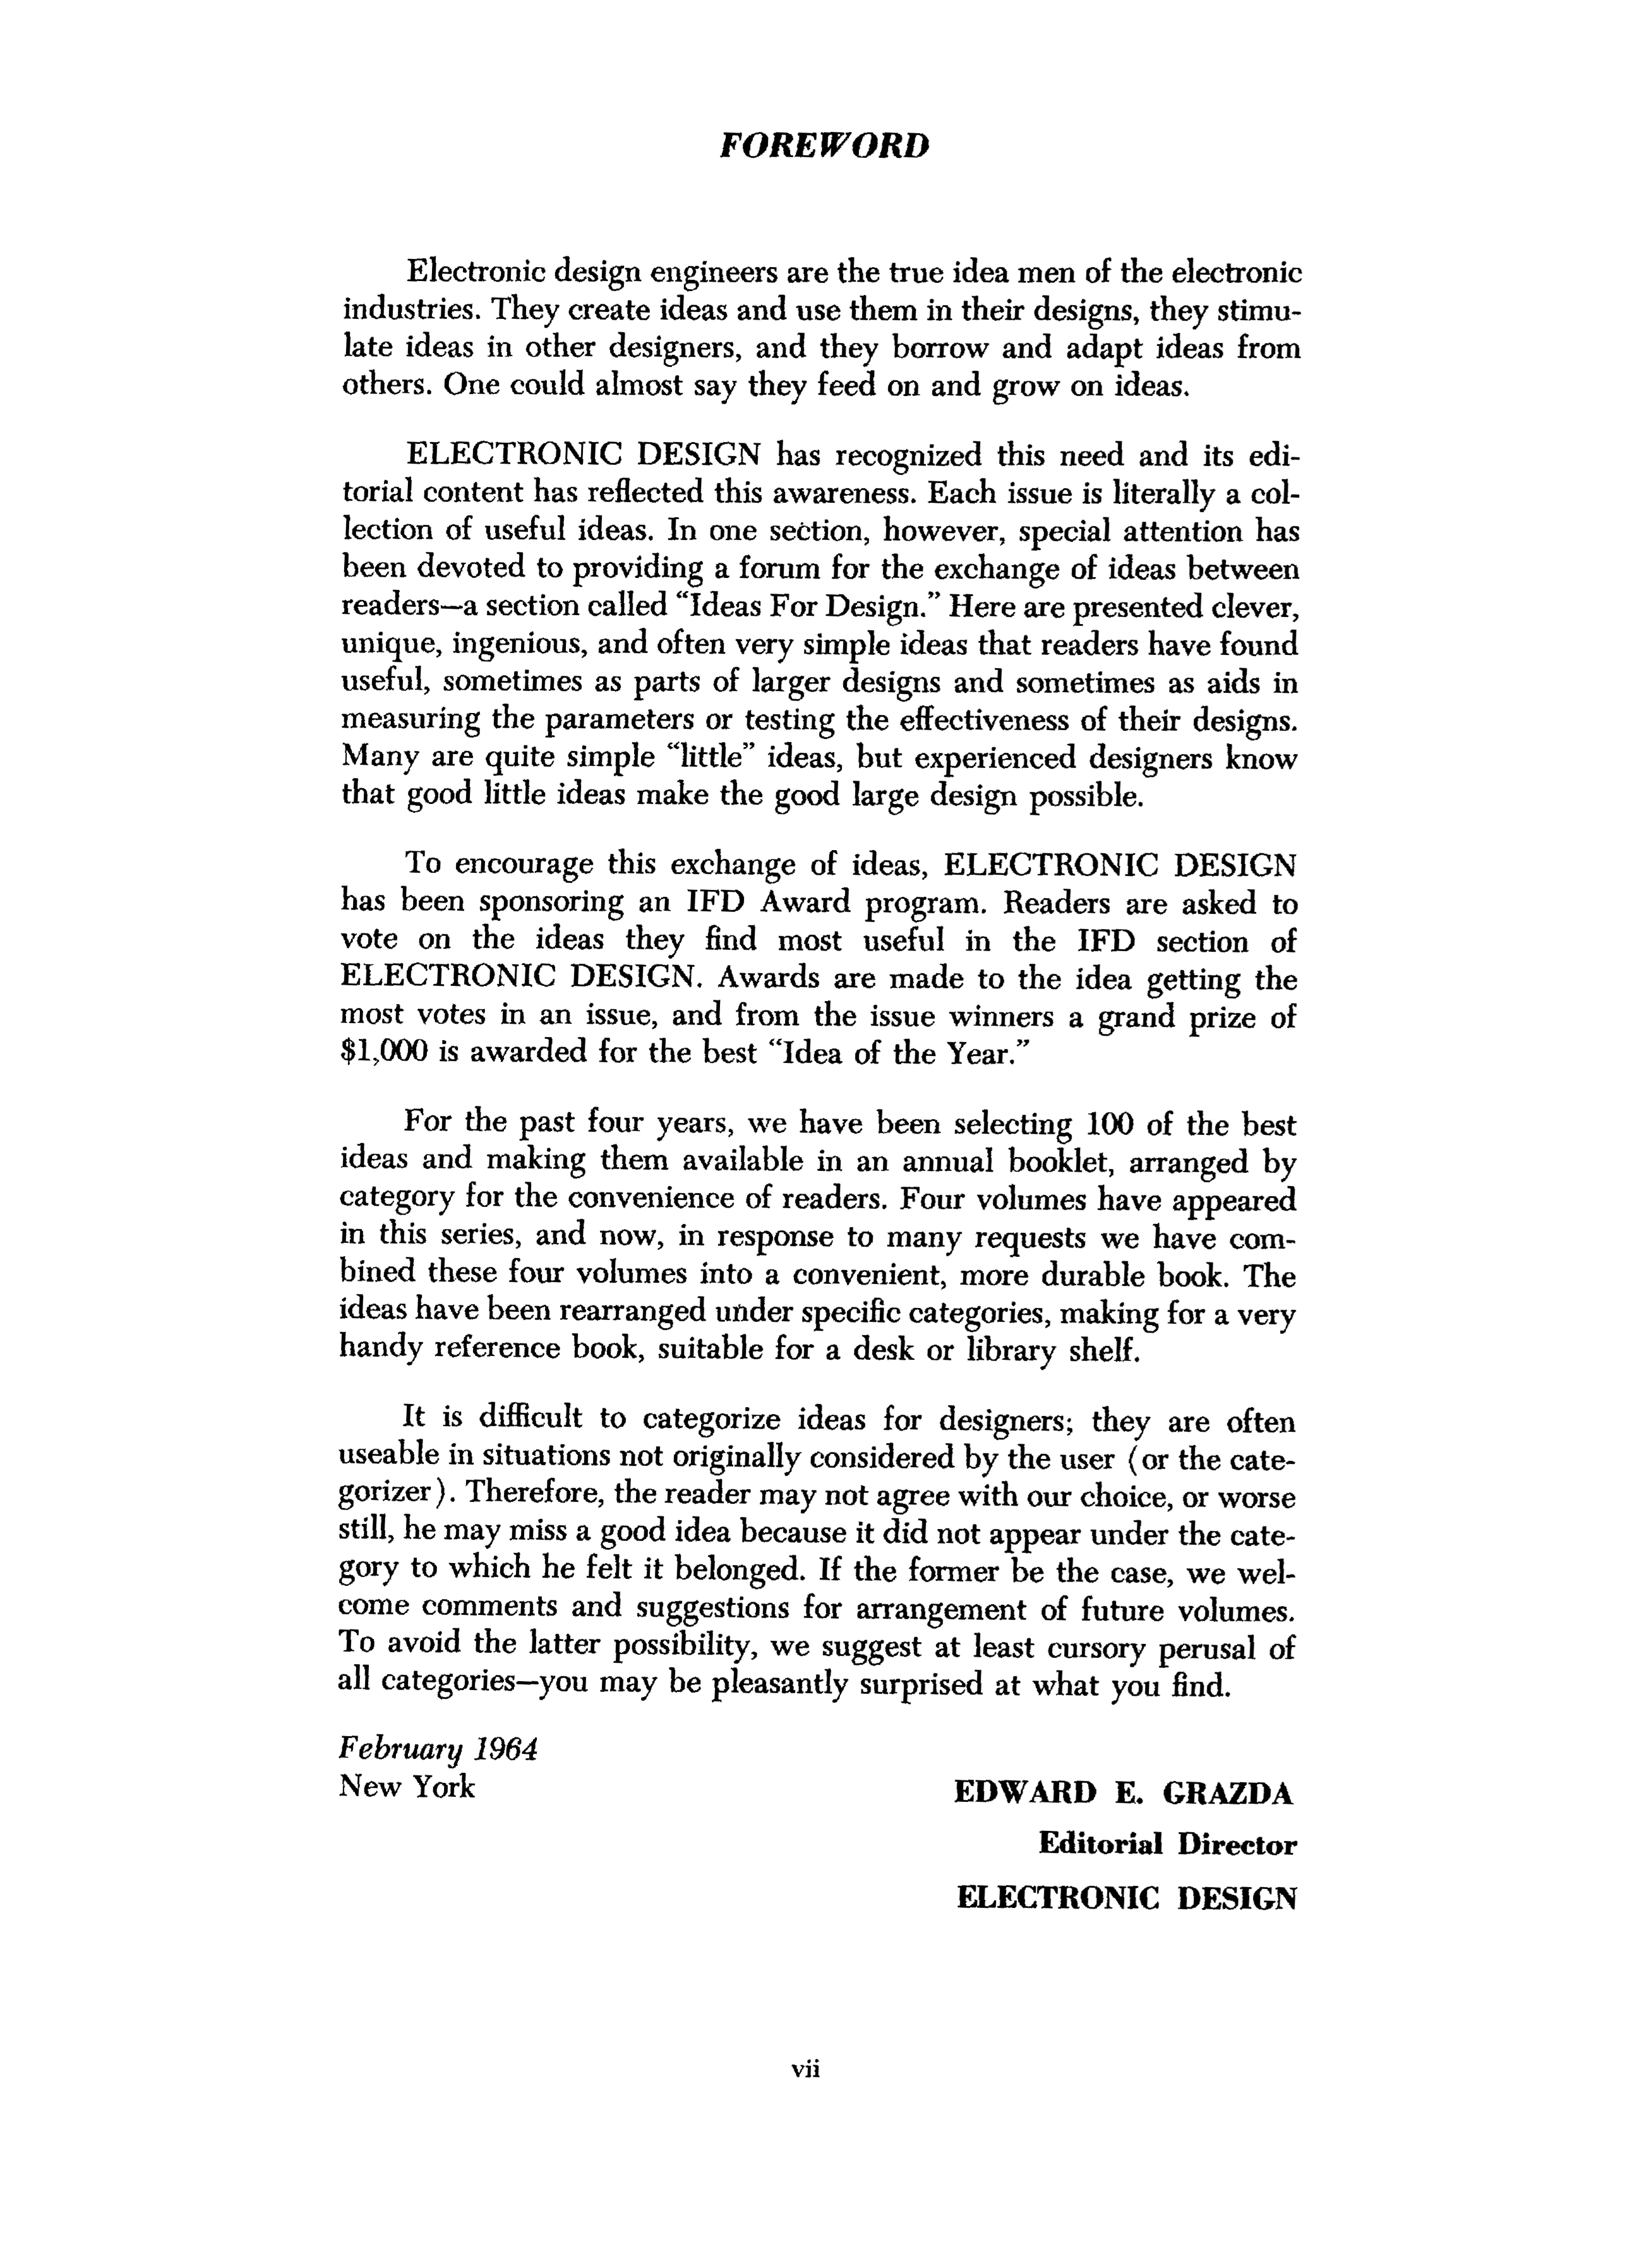

In [ ]:
visual.display_images(corrected_result, "corrected_image")

### Calculate scores for showing improvement

In [ ]:
detected = "\n".join([row.text for row in result.collect()])
corrected_detected = "\n".join([row.text for row in corrected_result.collect()])

# read original text
path_to_pdf_rotated_text = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/rotated/400.txt')

pdf_rotated_text = open(path_to_pdf_rotated_text, "r").read()

# compute scores
detected_score = visual.score(pdf_rotated_text, detected)
corrected_score = visual.score(pdf_rotated_text, corrected_detected)

#  print scores
print("Score without skew correction: {0}".format(detected_score))
print("Score with skew correction: {0}".format(corrected_score))

Score without skew correction: 0.6032562125107113
Score with skew correction: 0.9944524347647421


## Image Text Cleaner

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/visual-nlp/data/pdfs/noised.pdf


    Image #0:
    Origin: file:/content/noised.pdf
    Resolution: 300 dpi
    Width: 2479 px
    Height: 3508 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


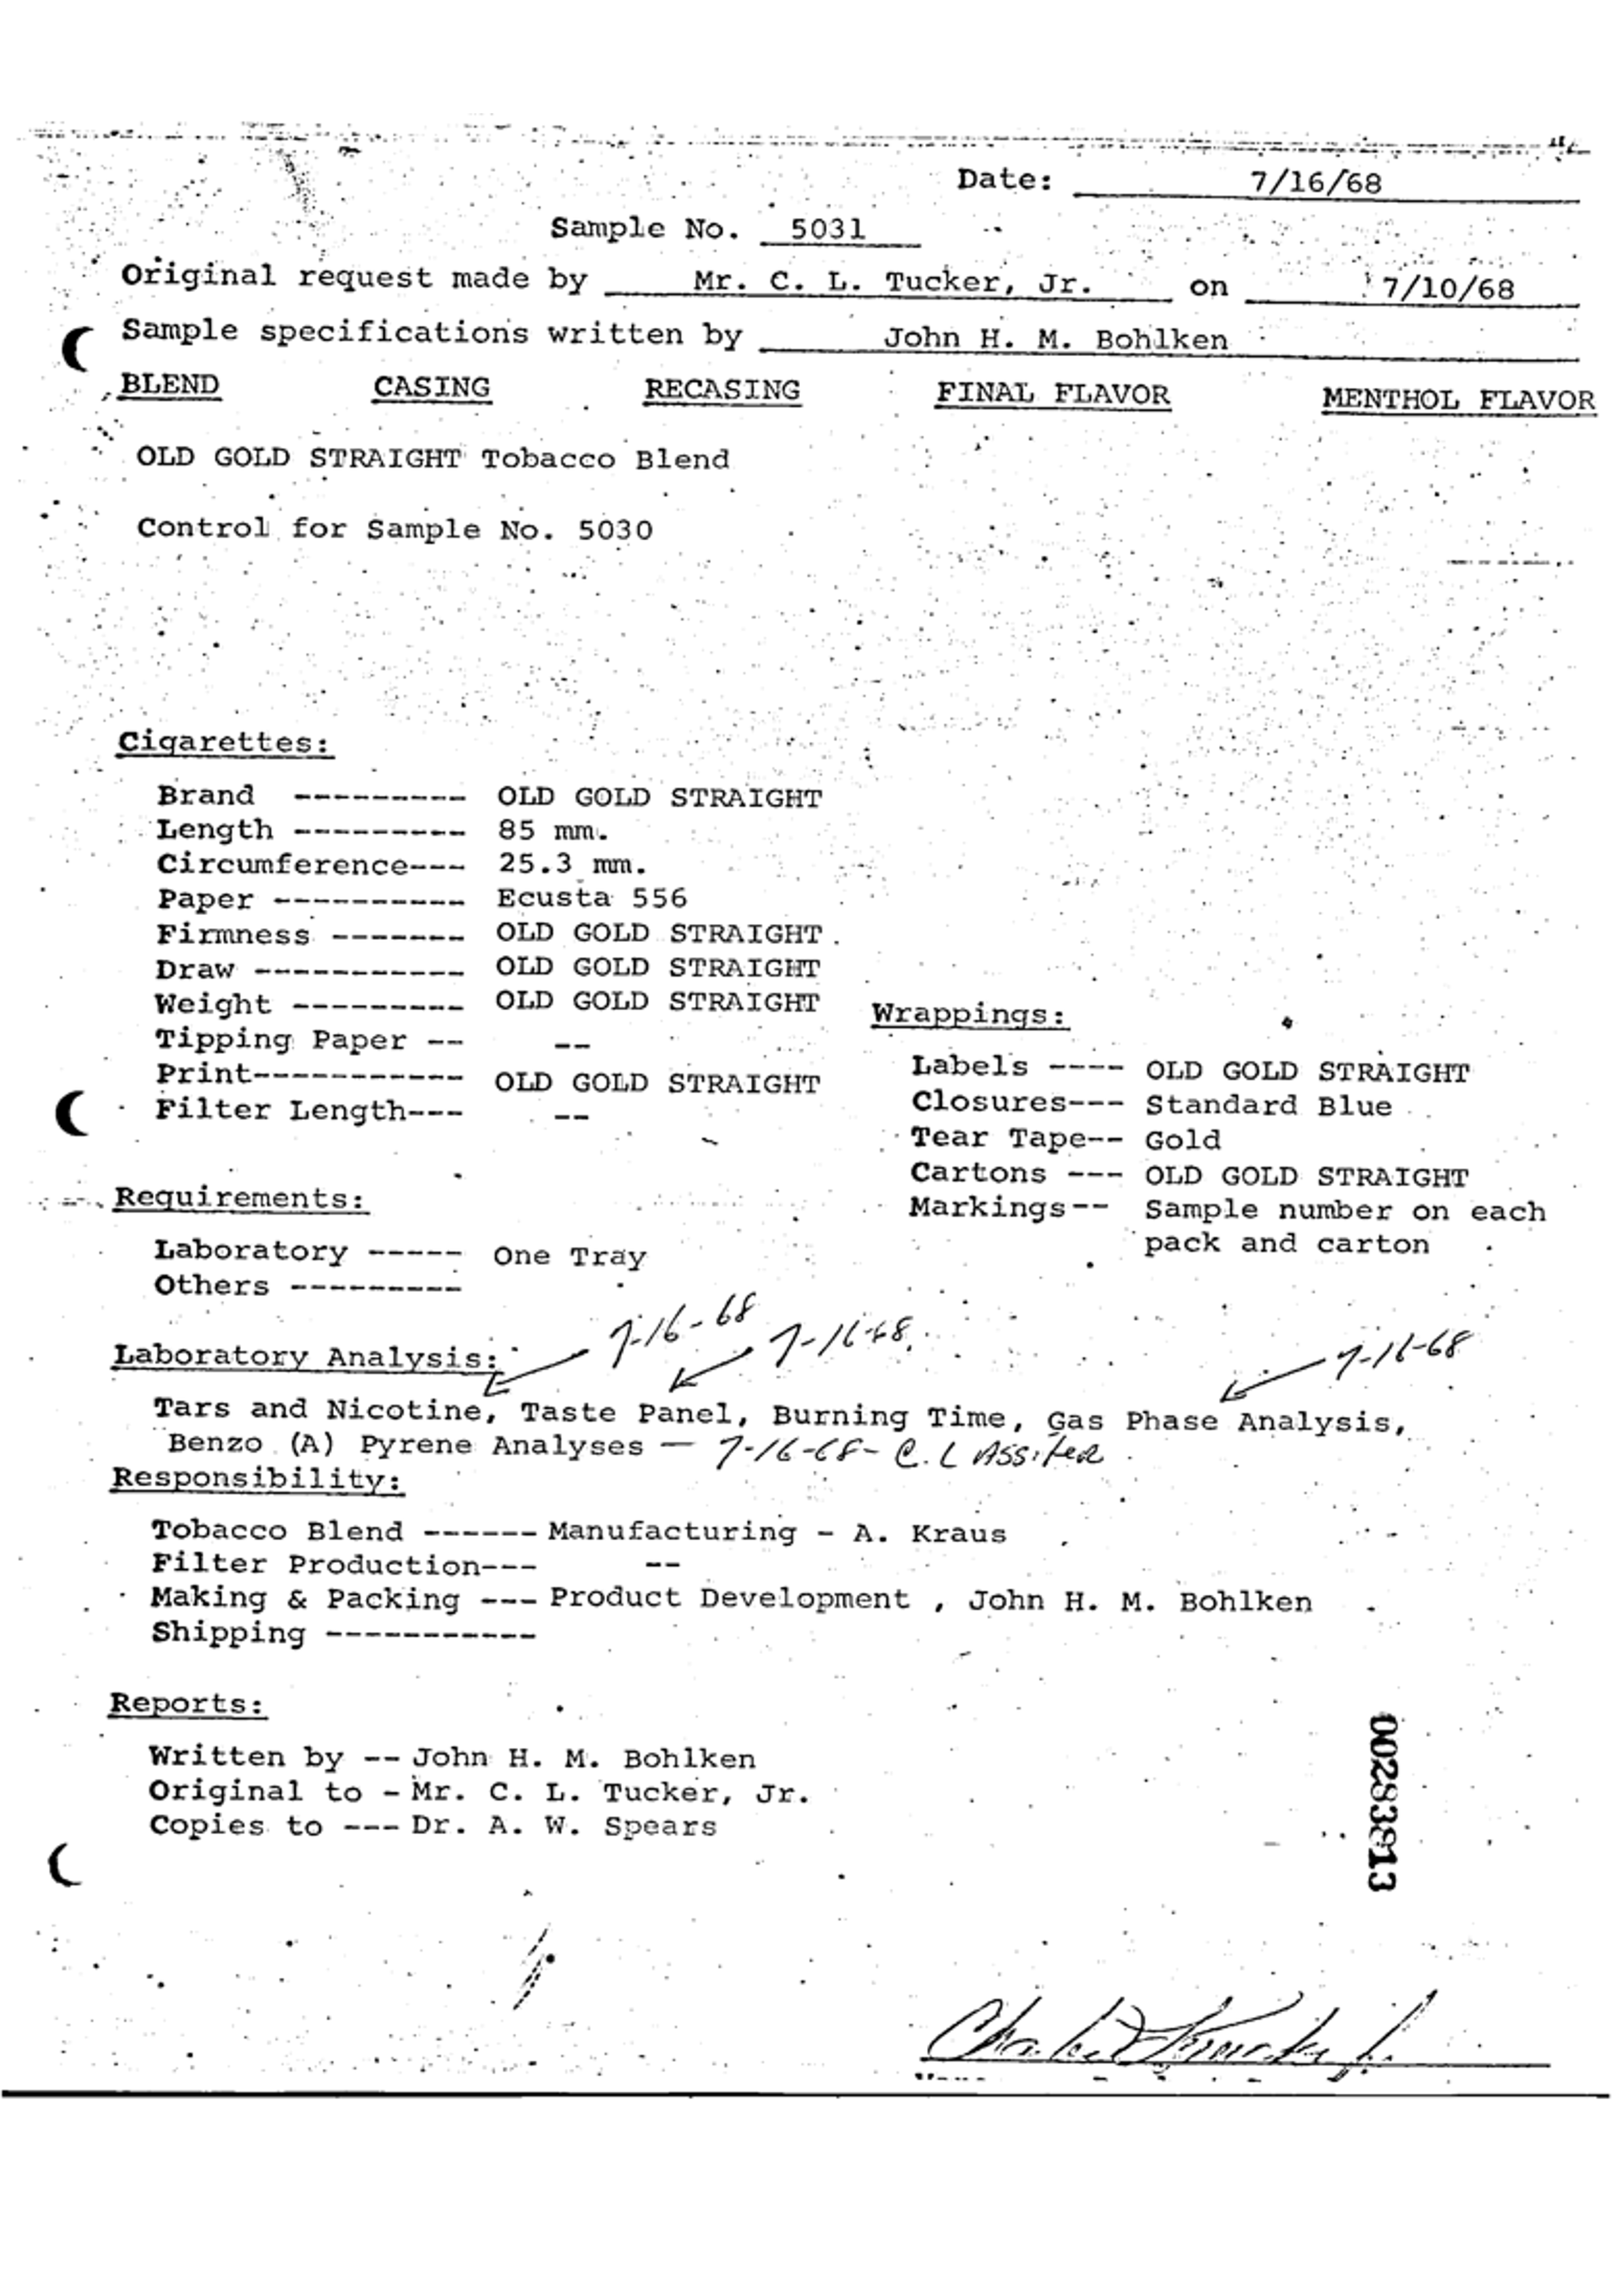

In [ ]:
pdf_noised_df = spark.read.format("binaryFile").load('noised.pdf').cache()

visual.display_pdf(pdf_noised_df)

In [ ]:
pdf_to_image = visual.PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setResolution(150)

ocr = visual.ImageToText() \
    .setInputCol("image") \
    .setOutputCol("text") \
    .setConfidenceThreshold(70) \
    .setIgnoreResolution(False)

cleaner = visual.ImageTextCleaner \
    .pretrained("text_cleaner_v1", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("corrected_image") \
    .setMedianBlur(0) \
    .setSizeThreshold(10) \
    .setTextThreshold(0.3) \
    .setLinkThreshold(0.2) \
    .setPadding(5) \
    .setBinarize(False)

ocr_corrected = visual.ImageToText() \
    .setInputCol("corrected_image") \
    .setOutputCol("corrected_text") \
    .setConfidenceThreshold(70) \
    .setIgnoreResolution(False)

pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr,
    cleaner,
    ocr_corrected
])

text_cleaner_v1 download started this may take some time.
Approximate size to download 73.5 MB


In [ ]:
results = pipeline.transform(pdf_noised_df).cache()

print(f"Detected text:\n{results.select('text').collect()[0].text}")

Detected text:
 

 

Sample specifications written by
CASING

Mr. C. L.

Sample No. _ 5031.
Original request made by

Date:

 

 

 

Tucker, Jr. "on

 

John H. M. Bohlken

 

RECASING

FINAL FLAVOR

 

 

~" OLD GOLD STRAIGHT Tobacco Blend

Control for Sample No. 5030

Cigarettes:

 

Filter Length---

. Requirements:

Laboratory
Others

OLD GOLD STRAIGHT
85 mm.

25.3 mn.

Ecusta 556 :
OLD GOLD STRAIGHT .
OLD GOLD STRAIGHT
OLD GOLD STRAIGHT

OLD GOLD STRAIGHT

 

 

Gold

MENTHOL FLAVOR

 

OLD GOLD STRAIGHT
Standard Blue

OLD GOLD STRAIGHT
Sample number on each

“pack and carton

Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,

Benzo (A) Pyrene Analyses —

Responsibility:

Tobacco Blend

Filter Production---

Manufacturing - A

- Kraus

- Making & Packing --- Product Development , John H. M. Bohlken .

Shipping

Written by -- John H. M. Bohlken
Original to -Mr. C. L. Tucker, Jr.
Copies to ---Dr. A. W. Spears

 

 




    Image #0:
    Origin: file:/content/noised.pdf
    Resolution: 150 dpi
    Width: 1239 px
    Height: 1754 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


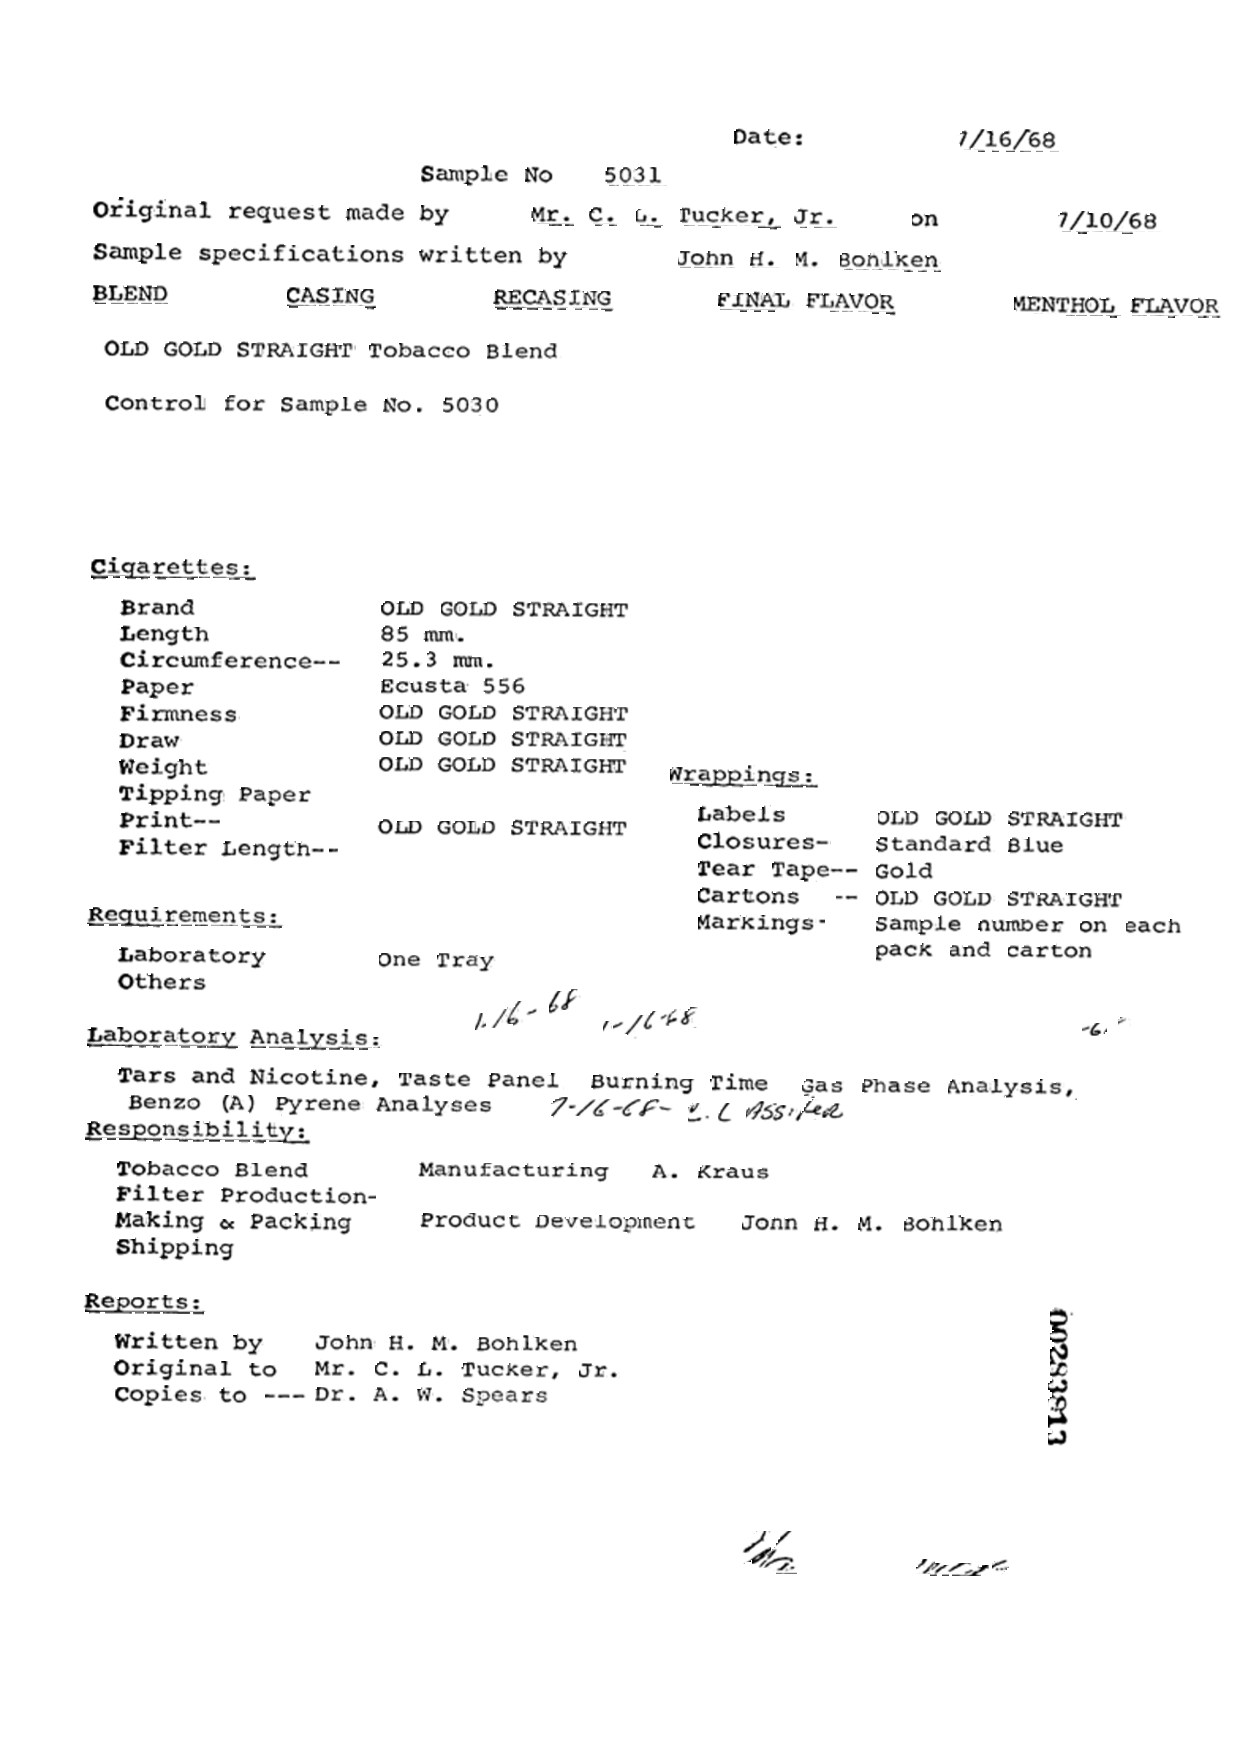

In [ ]:
visual.display_images(results, "corrected_image")

In [ ]:
print(f"Detected text from corrected image:\n{results.select('corrected_text').collect()[0].corrected_text}")

Detected text from corrected image:
Original request made by

Sample specifications written by

BLEND

CASING

Date: 7/16/68
Sample No 5031
Mr. C. G. Tucker, Jr. on 7/10/68
John H. M. Bonlken
RECASING FINAL FLAVOR MENTHOL FLAVOR

OLD GOLD STRAIGHT Tobacco Blend

Control for Sample No. 5030

Cigarettes:

Brand

Length
Circumference--
Paper

Firmness

Draw

Weight

Tipping Paper
Print--

Filter Length--

Requirements:

Laboratory
Others

OLD GOLD STRAIGHT
85 mm.

25.3 mn.

Ecusta 556

OLD GOLD STRAIGHT
OLD GOLD STRAIGHT
OLD GOLD STRAIGHT

Wrappings:

Labels OLD GOLD STRAIGHT

OLD GOLD STRAIGHT Closures- Standard Blue
Tear Tape-- Gold
Cartons -- OLD GOLD STRAIGHT
Markings- Sample number on each

pack and carton
One Tray
_ bt
6 re flb& be”

Laboratory Analysis:

Tars and Nicotine, Taste panel
Benzo (A) Pyrene Analyses

Responsibility:
Tobacco Blend

Manufacturing

Filter Production-

Making « Packing

Shipping

Reports:
Written by John H. M. Bohlken
Original to Mr. C. L. Tucker, Jr.

Copie

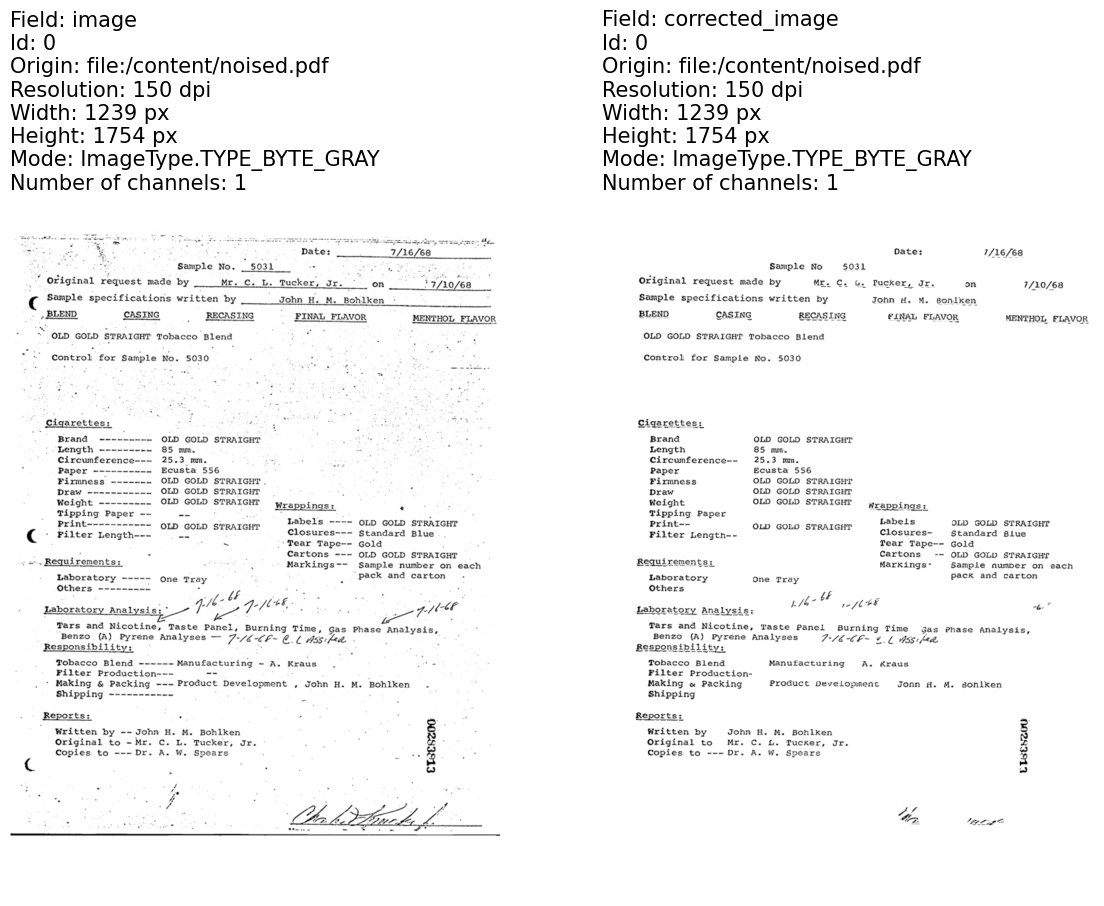

In [ ]:
visual.display_images_horizontal(results, "image,corrected_image")